In [139]:
import pandas as pd
import numpy as np

import re
import spacy

from textblob import TextBlob

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from nltk.corpus import stopwords
from datetime import datetime as dt
from fetch_news import MarketNews

sns.set_style("whitegrid")
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["axes.edgecolor"] = "k"

In [5]:
MarketNews?

Init signature: MarketNews(api_key)
Docstring:     
Fetches market news for a given stock ticker and index.

Attributes:
    url (str): URL endpoint for news API.
    query (dict): Parameters for API request.
    articles (list): List of fetched articles.
    data (DataFrame): Processed articles in DataFrame format.
    _api_key (str): API key for accessing the news API.
Init docstring: Initializes MarketNews with an API key.
File:           c:\users\aungs_tko91wk\eigen\wip[sentimentanalysis]\fetch_news\news.py
Type:           type
Subclasses:     

In [71]:
ticker = "COIN"
index = "NASDAQ"
api_key = "e6daf7c35aabe62faf71835d24505388"
base_url = "https://api.markets.sh/api/v1/symbols"

start = "2022-09-17"
end = "2023-09-17"

news = MarketNews(api_key=api_key)

news.get_news(
    index,
    ticker,
    base_url=base_url,
    start=start,
    end=end,
)

In [83]:
news_start = news.data.index.min()
news_end = news.data.index.max()

print(f"News start date: {news_start}")
print(f"News end date: {news_end}")
print(f"News timeframe: {(news_end - news_start).days} days")

News start date: 2022-10-06 12:00:00
News end date: 2023-09-09 01:12:18
News timeframe: 337 days


In [125]:
headlines = news.data.copy().iloc[::-1]
headlines = headlines.dropna()
headlines

,COIN
2022-10-06 12:00:00,Crypto Exchanges Cut Fees to Gain Market Share...
2022-10-07 14:49:06,Binance blockchain suffers $570 million hack
2022-10-07 20:38:00,Binance-linked blockchain hit by $570 million ...
2022-10-07 21:11:00,"Bitcoin, ether slide after September jobs data..."
2022-10-09 11:23:48,The fight to cut off the crypto funding Russia...
...,...
2023-08-22 12:54:55,Coinbase Invests in Circle and Shutters Centre...
2023-08-22 15:39:06,Coinbase takes stake in stablecoin firm Circle...
2023-08-23 02:49:29,Binance.US Partners With MoonPay to Convert Do...
2023-09-06 18:36:56,Coinbase Unveils Crypto Lending for Institutio...


In [126]:
nlp = spacy.load("en_core_web_sm")
stop_words = stopwords.words("english")

def process_text(text, lower_case, remove_stopwords, stop_words, regex_pattern="[^a-zA-Z\s]"):

    text = re.sub(r'^RT[\s]+', '', text)
    text = re.sub(r'\$\w*', '', text)
    text = re.sub(r'https?://[^\s\n\r]+', '', text)
    text = re.sub(r'https?://[A-Za-z0-9./]+','', text)
    text = re.sub(r'https//[A-Za-z0-9./]+','', text)
    text = text.replace("\n", "")
    text = re.sub('@[\w]+', '', text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    
    if lower_case:
        text = text.lower()
    text = re.sub(regex_pattern, "", text)
    word_list = text.split()

    return " ".join([word for word in word_list if word not in stop_words]) if remove_stopwords \
        else " ".join(word_list)

def get_entity(text, nlp, entity):
    tokenized = nlp(text)
    if entity is None:
        return [(ent.text, ent.label_) for ent in tokenized.ents]

In [127]:
headlines["processed_text"] = headlines[ticker].apply(
    process_text, lower_case=True, remove_stopwords=True, stop_words=stop_words
)

headlines.head()

,COIN,processed_text
2022-10-06 12:00:00,Crypto Exchanges Cut Fees to Gain Market Share...,crypto exchanges cut fees gain market share ri...
2022-10-07 14:49:06,Binance blockchain suffers $570 million hack,binance blockchain suffers million hack
2022-10-07 20:38:00,Binance-linked blockchain hit by $570 million ...,binancelinked blockchain hit million crypto theft
2022-10-07 21:11:00,"Bitcoin, ether slide after September jobs data...",bitcoin ether slide september jobs data fuels ...
2022-10-09 11:23:48,The fight to cut off the crypto funding Russia...,fight cut crypto funding russias invasion ukraine


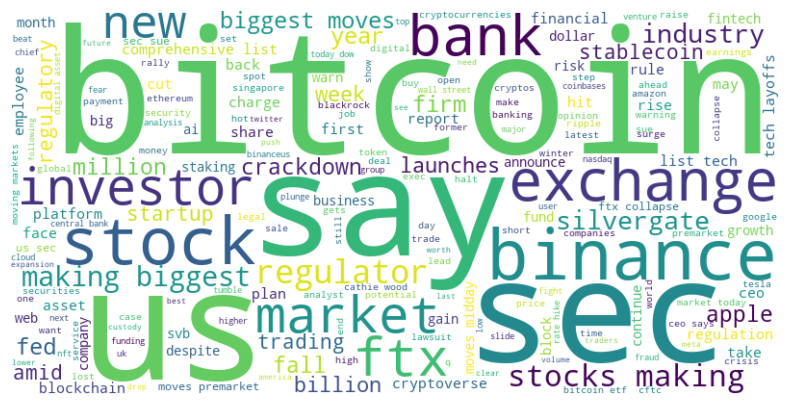

In [128]:
all_words = headlines["processed_text"].str.split().explode().to_list()
pruned_words = [w for w in all_words if w not in ["coinbase", "crypto", "cryptocurrency"]]
text_data = " ".join(pruned_words)

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_data)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [129]:
def run_textblob(text):
    sentiment_analysis = TextBlob(text)
    return sentiment_analysis.sentiment

def get_sentiment(text, aspect):
    if aspect == "polarity":
        return run_textblob(text)[0]
    elif aspect == "subjectivity":
        return run_textblob(text)[1]

headlines_textblob = headlines.copy()

headlines_textblob["polarity"] = headlines_textblob["processed_text"].apply(get_sentiment, aspect="polarity")
headlines_textblob["subjectivity"] = headlines_textblob["processed_text"].apply(get_sentiment, aspect="subjectivity")

headlines_textblob["sentiment"] = headlines_textblob["polarity"].apply(
    lambda x: "Positive" if x > 0 else "Negative" if x < 0 else "Neutral"
)

<Axes: >

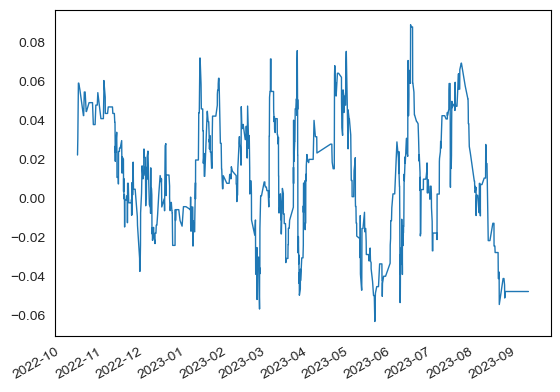

In [141]:
headlines_textblob.polarity.rolling(30).mean().plot(grid=False)

In [167]:
from transformers import BertConfig

^C
